In [1]:
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import lightgbm as lgb


from scipy import fftpack
from numpy.fft import rfft, irfft, rfftfreq

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../')

from spikennet.utils.augmentation import DataGenerator

## 1. Upload data

In [3]:
file_name = '../data/prep/data_132591818490899344_.txt'

dataset = pd.read_csv(file_name)
#dataset = pd.read_csv('../data/raw/data.csv')

In [4]:
# All combinations of 'Frequency' and 'Amplitude'
keys = dataset[['Frequency', 'Amplitude']]\
                                    .groupby(by=['Frequency', 'Amplitude'])\
                                    .sum()\
                                    .reset_index()\
                                    .to_numpy()

# Select index of combination of 'Frequency' and 'Amplitude'
key_index = 7
# Select value of combination of 'Frequency' and 'Amplitude'
keys[key_index]

# Define filter query for selecting data
filter_query = 'Frequency == {0} & Amplitude == {1}'.format(*keys[key_index])
# Select data with same combination of 'Frequency' and 'Amplitude'
data = dataset.query(filter_query)

In [5]:
# Clean data
clean_data_start_perc = 0.5 
clean_data_start_index = int(len(data)*clean_data_start_perc)
# Select columns 
columns = ['LeftYaw', 'RightYaw', 'RotAngleY', 'RotAngleZ']

data = data[clean_data_start_index:clean_data_start_index + 650][columns].values

Text(0.5, 0.98, 'States')

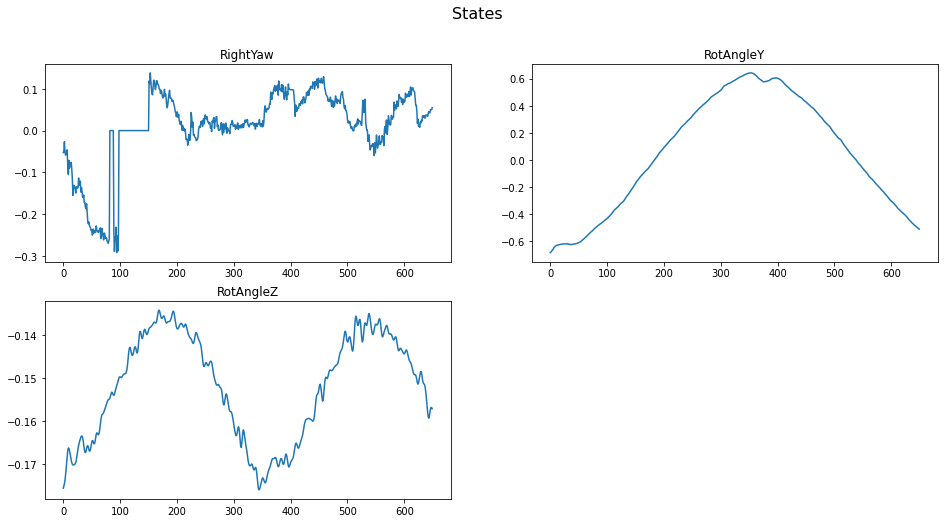

In [6]:
fig = plt.figure(figsize=(16, 8))

for i in range(len(columns)-1):
    ax = fig.add_subplot(2, 2, i+1)
    ax.plot(data.T[1+i])
    ax.set_title(columns[1+i])
    
fig.suptitle('States', fontsize=16)

## 2. Prepare data

### 2.1 Data split

In [7]:
# Number of window
k_windows = 5
# Width of window
width = int(len(data)/k_windows)

start_index = 0
end_index = width
(N,M) = data.shape

# Storage of windows
windows = np.zeros(shape=(k_windows, width, M))

In [8]:
windows[0].shape

(130, 4)

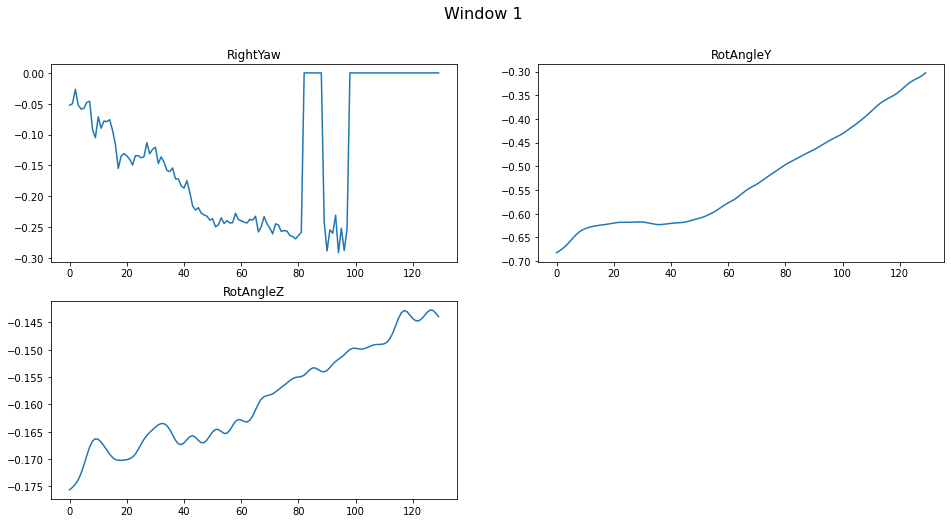

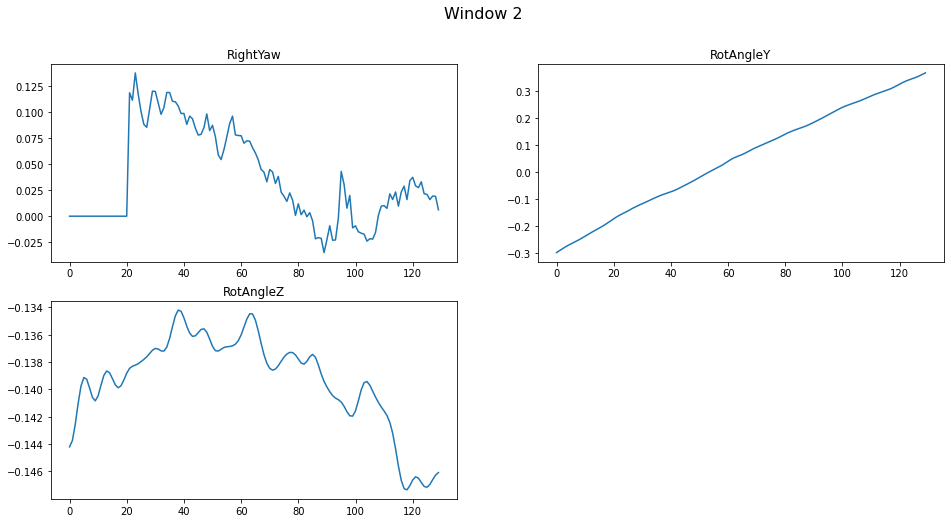

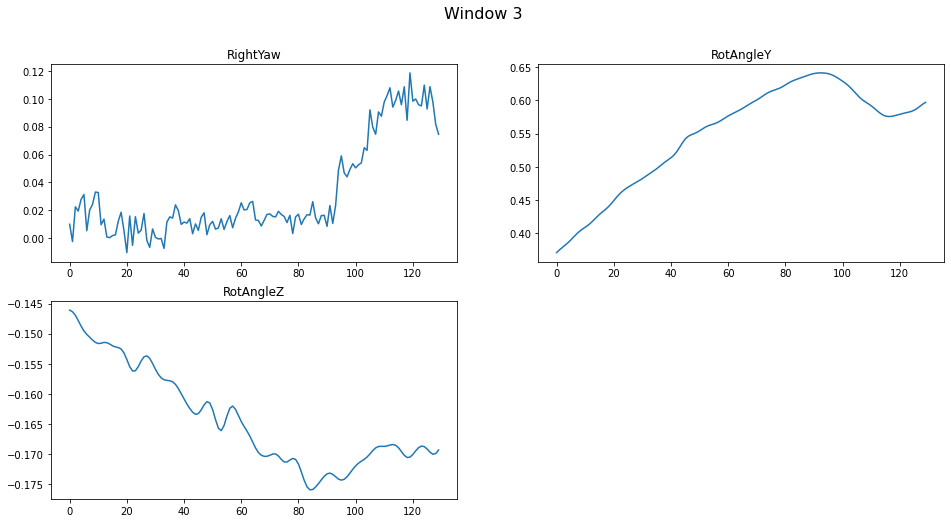

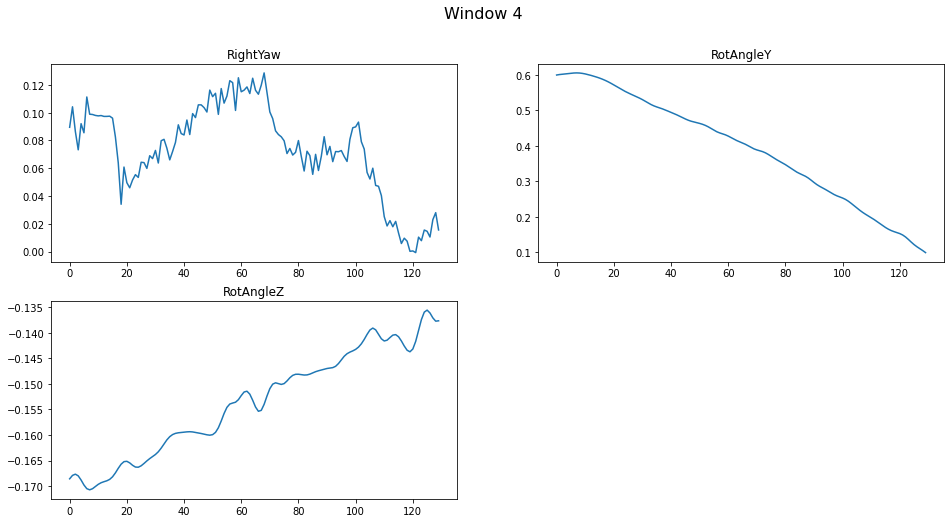

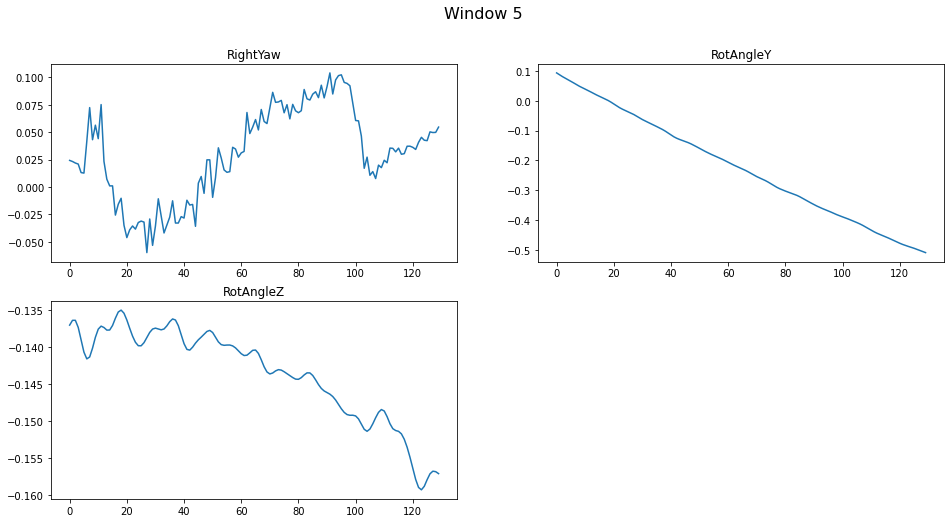

In [9]:
for k in range(k_windows):
    fig = plt.figure(figsize=(16, 8))
    tmp_data = data[start_index:end_index]
    for i in range(len(columns)-1):
        ax = fig.add_subplot(2, 2, i+1)
        ax.plot(tmp_data.T[1+i])
        ax.set_title(columns[1+i])
    
    windows[k] = tmp_data
    start_index = end_index 
    end_index += width
        
    fig.suptitle('Window {0}'.format(1+k), fontsize=16)

### 2.2 Data augmentation

In [10]:
# Object of class data-augmentation
dg = DataGenerator()

In [11]:
# Set the window for work
window_index = 1

In [12]:
# Count of exemple (k-1) synthetic data
k_augmentations = 6
# Storage of augmentations
augmentations = np.zeros(shape=(k_augmentations, width, M))

# Generate synthetic data
augmentations[0] = windows[window_index]
augmentations[1] = dg.time_inverse(windows[window_index])

for i in range(2, k_augmentations, 2):
    
    surrogate_fft = 0.8*windows[window_index] + 0.3*dg.fft(windows[window_index])
    surrogate_fft_ti = dg.time_inverse(surrogate_fft)

    augmentations[i] = surrogate_fft
    augmentations[i+1] = surrogate_fft_ti

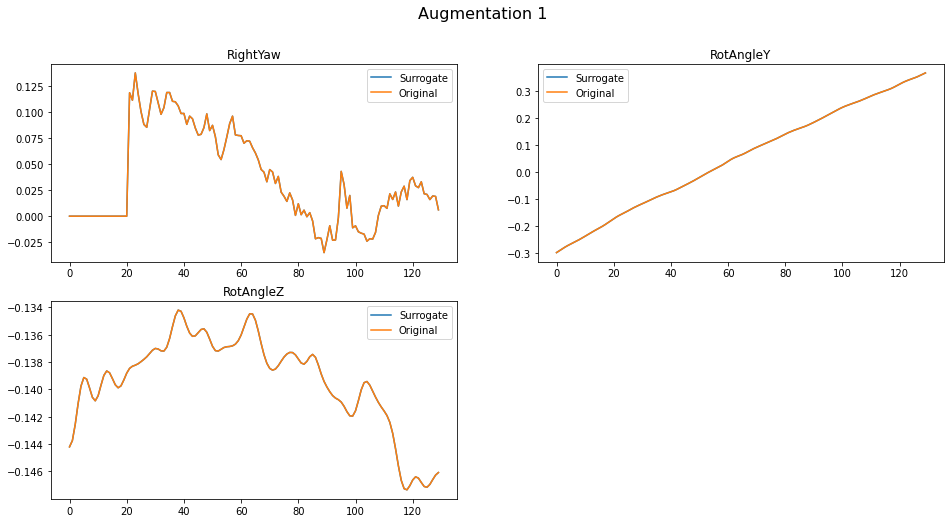

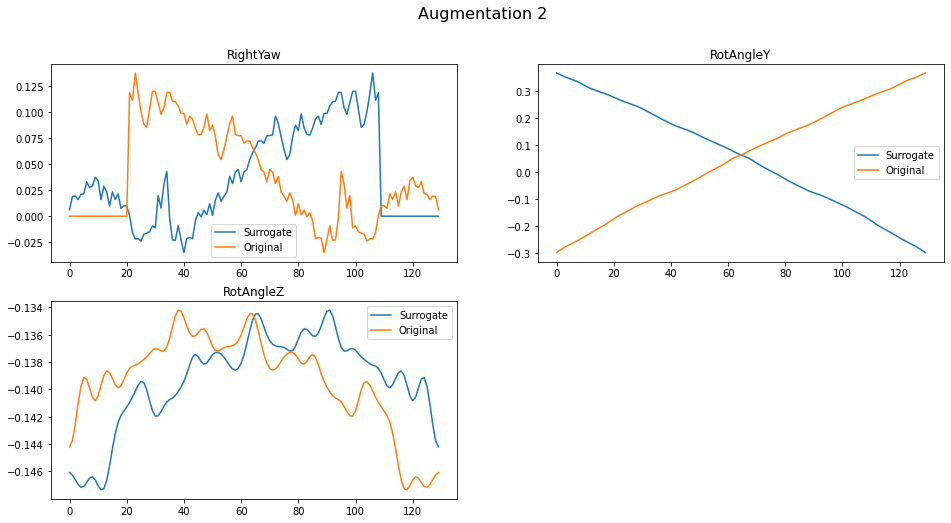

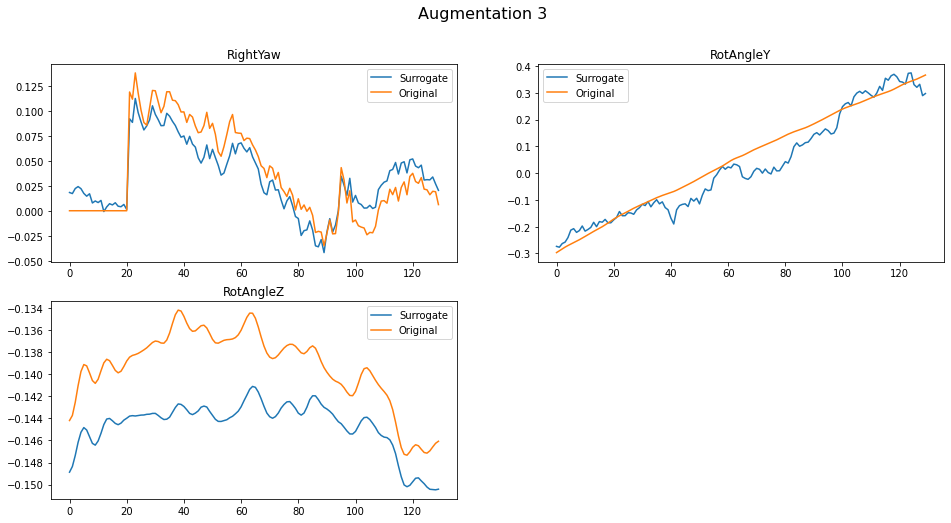

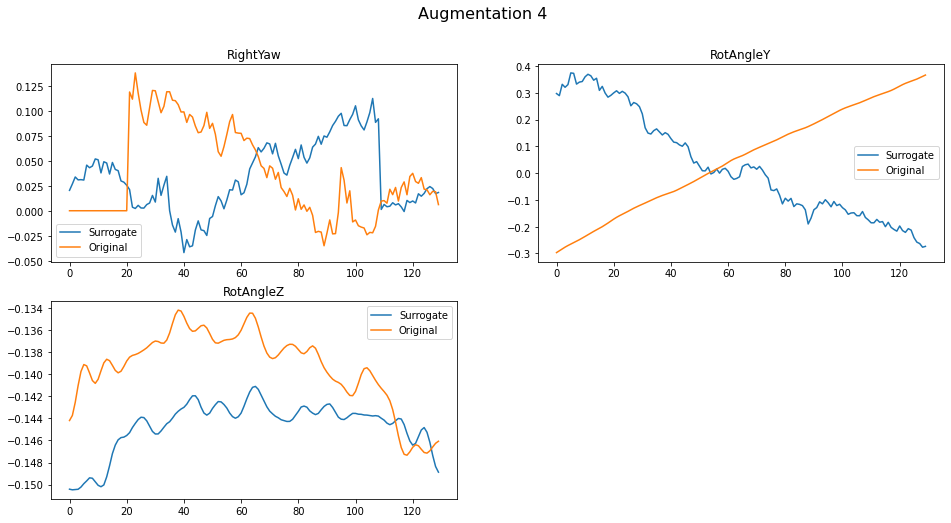

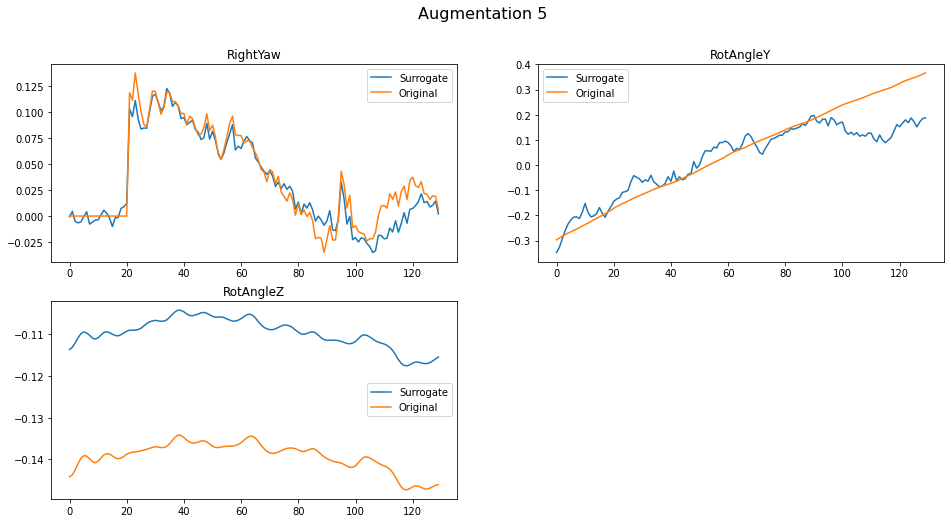

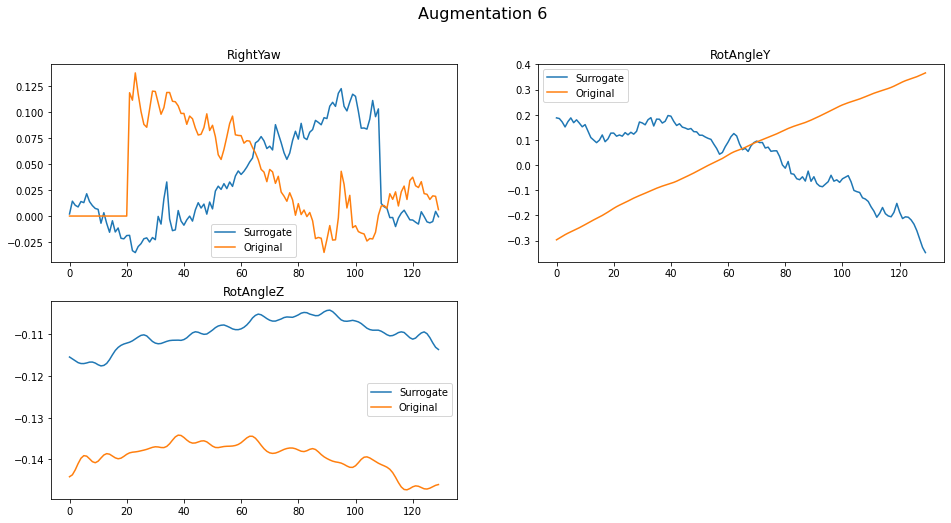

In [13]:
# Plot augmentations
for k in range(k_augmentations):
    fig = plt.figure(figsize=(16, 8))
    tmp_data = augmentations[k]
    for i in range(len(columns)-1):
        ax = fig.add_subplot(2, 2, i+1)
        ax.plot(tmp_data.T[1+i])
        ax.plot(augmentations[0].T[1+i])
        ax.legend(['Surrogate', 'Original'])
        ax.set_title(columns[1+i])
            
    fig.suptitle('Augmentation {0}'.format(1+k), fontsize=16)

## 3. Fit DNN

In [14]:
# ['Time', 'left_yaw', 'right_yaw', 'rot_angle_y_gf', 'rot_angle_z_gf']
nt = augmentations[0][:,0].shape[0]

In [15]:
def dff_transform(data, freq_bounds = (0, 0.99)):
    length, ncols = data.shape
    data_tranform = np.empty_like(data)
    frequencies = rfftfreq(length, d=1e-2)
    min_f, max_f = freq_bounds
    
    for i in range(ncols):
        fourier = rfft(data[:,i])
        ft_threshed = fourier.copy()
        ft_threshed[(min_f >= frequencies)] = 0
        ft_threshed[(max_f <= frequencies)] = 0
        ifourier = irfft(ft_threshed)

        data_tranform[:,i] = ifourier.copy()
        
    return data_tranform

def dff_transform_3d(data, freq_bounds = (0, 2.99)):
    length, ncols, nrows = data.shape
    dffs = []
    for i in range(ncols):
        dffs.append(dff_transform(data[:,:,i], freq_bounds=freq_bounds)[:, np.newaxis])
        
    return np.hstack(dffs)

In [16]:
x = dff_transform(windows[3][:,1:3])
u = windows[3][:,3].reshape(-1,1)
time = np.linspace(0, len(x), len(x))
split = int(len(x)*0.75)

x_lr = x[:split]
u_lr = u[:split]

x_vl = x[split:]
u_vl = u[split:]

In [17]:
lgb_reg = lgb.LGBMRegressor(verbose=-1)
lgb_reg.fit(u_lr, x_lr[:,0])
pred_lgb = lgb_reg.predict(u_vl)
train_lgb = lgb_reg.predict(u_lr)

/Users/a1/Work/spikennet/venv/lib/python3.7/site-packages/lightgbm/basic.py:448: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/Users/a1/Work/spikennet/venv/lib/python3.7/site-packages/lightgbm/basic.py:448: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/Users/a1/Work/spikennet/venv/lib/python3.7/site-packages/lightgbm/basic.py:448: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) , 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

def create_inout_sequences_v2(x, u, tw):
    inout_seq = []
    L = len(x)
    print(L-tw)
    for i in range(L-tw):
        train_seq = torch.FloatTensor(u[i:i+tw]).view(-1)
        train_label = torch.FloatTensor(np.array([x[i+tw]])).view(-1)
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [19]:
train_window = 222

tr_x_torch = torch.FloatTensor(x_lr).view(-1)
tr_u_torch = torch.FloatTensor(u_lr).view(-1)
vl_data_torch = torch.FloatTensor(x_vl).view(-1)
tr_seq_torch = create_inout_sequences_v2(x_lr[:,0], u_lr, train_window)

model = LSTM()
print(model)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

-125
LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [20]:
len(tr_seq_torch)

0

In [21]:
epochs = 15

for i in range(epochs):
    for k, (seq, labels) in enumerate(tr_seq_torch):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        if k%10 == 100:
            print(f'epoch: {i:3} window: {k:3} loss: {single_loss.item():10.8f}')

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

NameError: name 'single_loss' is not defined

In [ ]:
model.eval()
test_inputs = []
vldata = create_inout_sequences(x, train_window)
for data, label in vldata:
    seq = torch.FloatTensor(data[:,0])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
        #test_inputs.append(model(seq).detach().numpy())